In [1]:
import anndata.logging
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn


In [3]:
import mubind as mb

In [4]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [5]:
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [6]:
pwms = mb.datasets.archetypes()
# pwms = mb.datasets.genre()

HOCOMOCOv11_core_HUMAN_mono_meme_format.meme
HOCOMOCOv11_core_MOUSE_mono_meme_format.meme
JASPAR2018_CORE_vertebrates_non-redundant_pfms.meme
table_s3-1.meme
table_s3-2.meme
table_s3-3.meme
table_s3-4.meme
table_s3-5.meme
table_s3-6.meme
# motifs loaded 2179


In [7]:
clu = mb.datasets.archetypes_clu()
anno = mb.datasets.archetypes_anno()

In [8]:
reduced_groups = [p.to_numpy() for p in pwms]
# print(len(reduced_groups))

In [9]:
len(reduced_groups)

286

In [10]:
# reduced_groups = reduced_groups[:4]
# reduced_groups = reduced_groups[:1]

In [1]:

criterion = mb.tl.PoissonLoss()

n_rounds = 1
n_batches = 100
enr_series = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = mb.models.Multibind(
    datatype="selex",
    kernels=[0] + [m.shape[-1] for m in reduced_groups],
    n_rounds=n_rounds,
    init_random=False,
    n_batches=n_batches,
    enr_series=enr_series,
    use_dinuc=False,
    dinuc_mode=None# 'full',
).to(device)

model

NameError: name 'mb' is not defined

In [2]:
device

NameError: name 'device' is not defined

In [13]:


for i, mono_best in enumerate(reduced_groups):
    if mono_best.shape[-1] == 0:
        continue
    # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
# move the model a final time to the GPU
model = model.to(device)


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Using device: cuda:0


In [15]:
for pi, p in enumerate(reduced_groups):
    print(pi, p.shape)

0 (4, 9)
1 (4, 18)
2 (4, 9)
3 (4, 13)
4 (4, 14)
5 (4, 13)
6 (4, 17)
7 (4, 17)
8 (4, 13)
9 (4, 12)
10 (4, 15)
11 (4, 8)
12 (4, 11)
13 (4, 14)
14 (4, 12)
15 (4, 12)
16 (4, 17)
17 (4, 10)
18 (4, 18)
19 (4, 17)
20 (4, 11)
21 (4, 12)
22 (4, 17)
23 (4, 11)
24 (4, 12)
25 (4, 14)
26 (4, 14)
27 (4, 10)
28 (4, 15)
29 (4, 10)
30 (4, 10)
31 (4, 14)
32 (4, 9)
33 (4, 14)
34 (4, 10)
35 (4, 14)
36 (4, 12)
37 (4, 15)
38 (4, 16)
39 (4, 18)
40 (4, 12)
41 (4, 9)
42 (4, 14)
43 (4, 17)
44 (4, 18)
45 (4, 13)
46 (4, 18)
47 (4, 12)
48 (4, 12)
49 (4, 14)
50 (4, 18)
51 (4, 19)
52 (4, 10)
53 (4, 10)
54 (4, 12)
55 (4, 16)
56 (4, 14)
57 (4, 8)
58 (4, 15)
59 (4, 17)
60 (4, 17)
61 (4, 12)
62 (4, 15)
63 (4, 14)
64 (4, 10)
65 (4, 8)
66 (4, 12)
67 (4, 10)
68 (4, 10)
69 (4, 12)
70 (4, 6)
71 (4, 15)
72 (4, 10)
73 (4, 13)
74 (4, 9)
75 (4, 10)
76 (4, 12)
77 (4, 9)
78 (4, 10)
79 (4, 21)
80 (4, 12)
81 (4, 17)
82 (4, 10)
83 (4, 14)
84 (4, 12)
85 (4, 13)
86 (4, 20)
87 (4, 9)
88 (4, 9)
89 (4, 8)
90 (4, 12)
91 (4, 20)
92 (4, 19)


True
12
0 out of 287...


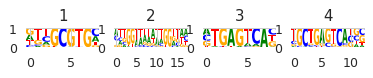

In [16]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=9, n_cols=12, stop_at=5) # n_cols=len(reduced_groups))


In [17]:
def unfreeze(model, feat_lab=None, position=None):
    # block mononucleotide but free dinucleotide and activities to calibrate themselves during training
    verbose = 1
    for ki in range(2 + 1):
        mask_pos = (ki == position if position is not None else True)
        mask_mono = (feat_lab == 'mono') and mask_pos
        mask_dinuc = (feat_lab == 'dinuc') and mask_pos
        if verbose != 0:
            print("setting grad status of kernel (mono, dinuc) at %i to (%i, %i)" % (ki, mask_mono, mask_dinuc))
        model.binding_modes.update_grad_mono(ki, mask_mono)
        model.binding_modes.update_grad_di(ki, mask_dinuc)

### Freeze weights and train

In [18]:
# unfreeze(model, None)
# model.binding_modes.update_grad_mono(0, True)
# model.binding_modes.update_grad_di(0, True)

In [19]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [20]:
# atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_sample_c16918_p50000.h5ad'
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed.h5ad'
os.path.exists(atac_path)

True

In [21]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


In [22]:
!ls -ltrh ../../../annotations/scatac/

total 2.9G
-rwxrwxrwx 1 rio rio 2.3G Jan 23 23:02 pancreas_multiome_2022_processed.h5ad
-rwxrwxrwx 1 rio rio 381K Jan 24 19:01 pancreas_multiome_2022_processed_sample_100.h5ad
-rwxrwxrwx 1 rio rio 2.4M Jan 24 19:01 pancreas_multiome_2022_processed_sample_1000.h5ad
-rwxrwxrwx 1 rio rio 1.2M Jan 24 19:01 pancreas_multiome_2022_processed_sample_500.h5ad
-rwxrwxrwx 1 rio rio  50M Jan 25 10:54 pancreas_multiome_2022_processed_sample_10000.h5ad
-rwxrwxrwx 1 rio rio 122M Feb  3 09:15 pancreas_multiome_2022_processed_sample_c16918_p20000.h5ad
-rwxrwxrwx 1 rio rio 170M Feb  3 09:15 pancreas_multiome_2022_processed_sample_c16918_p30000.h5ad
-rwxrwxrwx 1 rio rio 325M Feb  3 09:15 pancreas_multiome_2022_processed_sample_c16918_p50000.h5ad


In [23]:
import scanpy as sc
adata = sc.read_h5ad(atac_path)
print(adata.shape)

(16918, 242922)


In [24]:
import gc
gc.collect()

19886

In [25]:
rna = adata[:,adata.var.modality == 'GEX'].copy()
atac = adata[:,adata.var.modality == 'ATAC'].copy()


In [26]:
atac.shape, rna.shape

((16918, 228259), (16918, 14663))

In [27]:
# del adata
gc.collect()

612

In [141]:
# rna = adata[:,adata.var.modality == 'GEX'].copy()

n_sample_cells = 350
n_sample_peaks = n_sample_cells * 2


In [142]:
print(n_sample_cells, n_sample_peaks)

350 700


(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

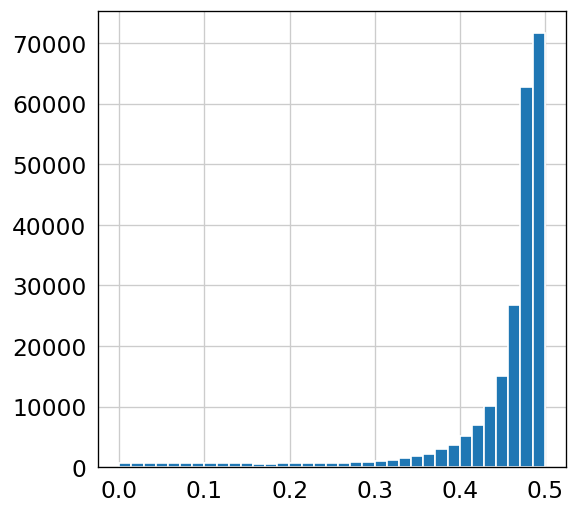

In [143]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)

## Make a selection of RNA seq features

In [144]:
rna.var['modality']

Xkr4              GEX
Mrpl15            GEX
Lypla1            GEX
Gm37988           GEX
Tcea1             GEX
                 ... 
Vamp7             GEX
Tmlhe             GEX
AC149090.1        GEX
CAAA01118383.1    GEX
CAAA01147332.1    GEX
Name: modality, Length: 14663, dtype: category
Categories (1, object): ['GEX']

In [145]:
rna.var_names_make_unique()

In [146]:
rna.var_names.value_counts()

Xkr4              1
Ddx56             1
Ogdh              1
Zmiz2             1
Ppia              1
                 ..
Fis1              1
Znhit1            1
Plod3             1
Vgf               1
CAAA01147332.1    1
Length: 14663, dtype: int64

In [147]:
obs_sample = pd.Index(np.random.choice(rna.obs_names, n_sample_cells, replace=False))
var_sample = pd.Index(np.random.choice(rna.var_names, n_sample_peaks, replace=False))

In [148]:
var_sample.value_counts()

Lpgat1     1
Mindy1     1
Marchf2    1
Atg9a      1
Pctp       1
          ..
Fxn        1
Gm50394    1
Syne2      1
Prpf3      1
Setx       1
Length: 700, dtype: int64

In [149]:
# var_sample = adata.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = rna[rna.obs_names.isin(obs_sample), rna.var_names.isin(var_sample)]
ad.shape

(350, 700)

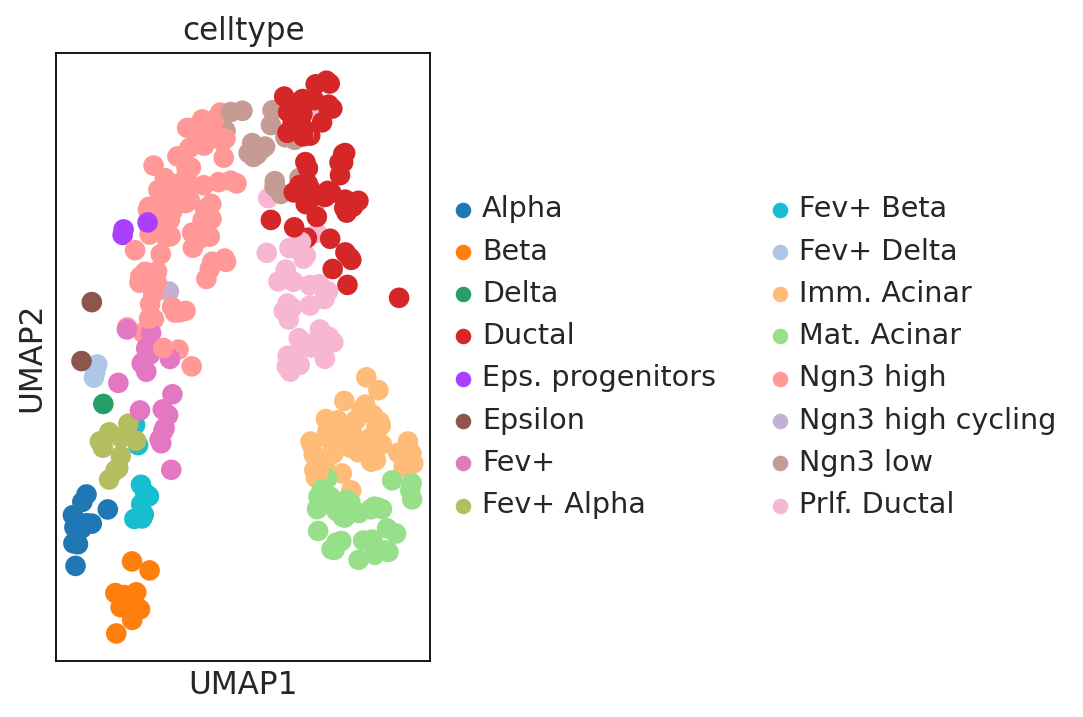

In [150]:
# contributions per newly added kernel
from matplotlib import rcParams
rcParams['figure.figsize'] = 3, 5
rcParams['figure.dpi'] = 80
sc.pl.umap(ad, color='celltype')

In [151]:
ad.var_names

Index(['Kcnq5', 'Fhl2', 'Mettl21c', 'Pgap1', 'Mob4', 'Kansl1l',
       '4930556G22Rik', 'Mreg', 'Pecr', 'Marchf4',
       ...
       'Zfyve27', 'Crtac1', 'Npm3', 'Atp5md', 'Gm50394', 'Dusp5', 'Gfra1',
       'Eno4', 'Csf2ra', 'CAAA01118383.1'],
      dtype='object', length=700)

### use mouse TSS coordinates

In [152]:
tss_coordinates = pd.read_csv('../../../../starpy/data/mm10/TSS.in', header=None, sep='\t')
tss_coordinates.columns = ['chr', 'position', 'strand', 'gene_symbol']

In [153]:
ad.var['has_tss'] = ad.var_names.isin(tss_coordinates['gene_symbol'])
ad.var['has_tss'].value_counts()

True     619
False     81
Name: has_tss, dtype: int64

In [154]:
for c in ['chr', 'position', 'strand']:
    ad.var[c] = ad.var_names.map(tss_coordinates.set_index('gene_symbol')[c].to_dict())


In [155]:
ad = ad[:,ad.var.has_tss].copy()

In [156]:
extend = 1000
ad.var['start'] = ad.var['position'].astype(int)
ad.var['end'] = ad.var['start'] + np.where(ad.var['strand'] == '+', -extend, extend)

In [157]:
ad.shape

(350, 619)

In [158]:
ad.var['chr'].value_counts()

chr7     57
chr11    52
chr2     51
chr5     46
chr1     38
chr3     35
chr4     35
chr6     31
chr9     31
chr19    29
chr8     29
chr17    27
chr10    24
chr15    23
chr14    23
chr12    20
chr18    20
chrX     17
chr16    16
chr13    14
chrY      1
Name: chr, dtype: int64

In [159]:
ad.var

modality  has_tss    chr    position strand     start       end
Kcnq5         GEX     True   chr1  21961942.0      -  21961942  21962942
Fhl2          GEX     True   chr1  43196761.0      -  43196761  43197761
Mettl21c      GEX     True   chr1  44020006.0      -  44020006  44021006
Pgap1         GEX     True   chr1  54557684.0      -  54557684  54558684
Mob4          GEX     True   chr1  55131245.0      +  55131245  55130245
...           ...      ...    ...         ...    ...       ...       ...
Npm3          GEX     True  chr19  45749563.0      -  45749563  45750563
Dusp5         GEX     True  chr19  53529318.0      +  53529318  53528318
Gfra1         GEX     True  chr19  58455398.0      -  58455398  58456398
Eno4          GEX     True  chr19  58943425.0      +  58943425  58942425
Csf2ra        GEX     True  chr19  61228418.0      -  61228418  61229418

[619 rows x 7 columns]

In [160]:
ad.var['summit.start'] = np.where(ad.var['start'] > ad.var['end'], ad.var['end'], ad.var['start']) #  - extend
ad.var['summit.end'] = np.where(ad.var['start'] > ad.var['end'], ad.var['start'], ad.var['end']) #  + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)
ad.var['summit.end'] - ad.var['summit.start']

Kcnq5       1000
Fhl2        1000
Mettl21c    1000
Pgap1       1000
Mob4        1000
            ... 
Npm3        1000
Dusp5       1000
Gfra1       1000
Eno4        1000
Csf2ra      1000
Length: 619, dtype: int64

In [161]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

convert bed to fasta
/tmp/tmpdhfyd0d1
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpdhfyd0d1 -fo /tmp/tmp_35vn6xa
get fasta
/tmp/tmp_35vn6xa


In [162]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [163]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

# general binarization
# next_data[next_data != 0] = 1

In [164]:

next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index


(619, 351)

In [165]:
subselect = False
if subselect:
    n_cells = 10000
    top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]
    # next_data = next_data.head(10000)
    next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
    next_data_sel
    print(next_data_sel.shape)


In [166]:
next_data_sel = next_data.copy()
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0

print(df.shape)
df = df[~zero_counts] # remove zeroes

df.shape

(619, 350)


(619, 350)

In [167]:
df

0    1    2    3    4    \
seq                                                                           
GCAGGGTTCGAGTCTGTCTGTCCCCTGCACCCCGGCAGAATACCGGC...  0.0  0.0  0.0  0.0  0.0   
GTGGGACTTTTGTCAGCAGAGTTATAAATAAGGCATGTCCACTGGCC...  0.0  0.0  1.0  0.0  6.0   
GCTAGTTGGAGTTCAAGTTATTTATGGTAGCATTACCCAGACCTCTC...  0.0  0.0  0.0  0.0  0.0   
GCGGAGCCCGCCAGCACCCCCTCCCCTTCGCCTGCCGCTCAGCGCGC...  0.0  0.0  0.0  0.0  3.0   
CTTTGAATTCTAAACAATTCTTTTAACTGTTTTGCTTATTTACTTGC...  2.0  3.0  2.0  0.0  1.0   
...                                                 ...  ...  ...  ...  ...   
CGGCCGTGAGCGCCCCGCCCCCCGCCTCAGCCAGTTCCGGTCCCGCC...  2.0  0.0  0.0  1.0  0.0   
CATAATCCCACAAATCCAGAAGCCACCCGGACAACAGTTTAACTGGA...  0.0  0.0  0.0  0.0  0.0   
GGCTGGAGGGGAGGTGGCGATGGGTTCTCAAGTGGAATGAGAAAACT...  0.0  0.0  0.0  0.0  0.0   
TGTGTGATGACCCATCACACCACAGAAAGGAAATCGTCCTCAAAGAG...  0.0  0.0  0.0  0.0  0.0   
GCTTCCTCTTCCTCATCTGCAGGTTGGGAAACCTAGAGGGGAAGGAA...  0.0  0.0  0.0  2.0  2.0   

                                                    5    6    7    8    9    \
seq                                                                           
GCAGGGTTCGAGTCTGTCTGTCCCCTGCACCCCGGCAGAATACCGGC...  0.0  0.0  0.0  1.0  0.0   
GTGGGACTTTTGTCAGCAGAGTTATAAATAAGGCATGTCCACTGGCC...  0.0  1.0  0.0  0.0  1.0   
GCTAGTTGGAGTTCAAGTTATTTATGGTAGCATTACCCAGACCTCTC...  0.0  0.0  0.0  0.0  0.0   
GCGGAGCCCGCCAGCACCCCCTCCCCTTCGCCTGCCGCTCAGCGCGC...  1.0  1.0  2.0  0.0  0.0   
CTTTGAATTCTAAACAATTCTTTTAACTGTTTTGCTTATTTACTTGC...  3.0  6.0  1.0  1.0  3.0   
...                                                 ...  ...  ...  ...  ...   
CGGCCGTGAGCGCCCCGCCCCCCGCCTCAGCCAGTTCCGGTCCCGCC...  3.0  0.0  0.0  0.0  0.0   
CATAATCCCACAAATCCAGAAGCCACCCGGACAACAGTTTAACTGGA...  1.0  2.0  0.0  0.0  0.0   
GGCTGGAGGGGAGGTGGCGATGGGTTCTCAAGTGGAATGAGAAAACT...  0.0  2.0  1.0  0.0  0.0   
TGTGTGATGACCCATCACACCACAGAAAGGAAATCGTCCTCAAAGAG...  0.0  0.0  0.0  0.0  0.0   
GCTTCCTCTTCCTCATCTGCAGGTTGGGAAACCTAGAGGGGAAGGAA...  0.0  0.0  0.0  0.0  0.0   

                                                    ...  340  341  342  343  \
seq                                                 ...                       
GCAGGGTTCGAGTCTGTCTGTCCCCTGCACCCCGGCAGAATACCGGC...  ...  5.0  0.0  0.0  8.0   
GTGGGACTTTTGTCAGCAGAGTTATAAATAAGGCATGTCCACTGGCC...  ...  0.0  0.0  0.0  0.0   
GCTAGTTGGAGTTCAAGTTATTTATGGTAGCATTACCCAGACCTCTC...  ...  0.0  0.0  0.0  0.0   
GCGGAGCCCGCCAGCACCCCCTCCCCTTCGCCTGCCGCTCAGCGCGC...  ...  0.0  0.0  5.0  2.0   
CTTTGAATTCTAAACAATTCTTTTAACTGTTTTGCTTATTTACTTGC...  ...  4.0  0.0  1.0  5.0   
...                                                 ...  ...  ...  ...  ...   
CGGCCGTGAGCGCCCCGCCCCCCGCCTCAGCCAGTTCCGGTCCCGCC...  ...  4.0  2.0  0.0  5.0   
CATAATCCCACAAATCCAGAAGCCACCCGGACAACAGTTTAACTGGA...  ...  0.0  0.0  0.0  1.0   
GGCTGGAGGGGAGGTGGCGATGGGTTCTCAAGTGGAATGAGAAAACT...  ...  0.0  0.0  0.0  2.0   
TGTGTGATGACCCATCACACCACAGAAAGGAAATCGTCCTCAAAGAG...  ...  0.0  0.0  0.0  0.0   
GCTTCCTCTTCCTCATCTGCAGGTTGGGAAACCTAGAGGGGAAGGAA...  ...  1.0  0.0  0.0  0.0   

                                                    344  345  346  347  348  \
seq                                                                           
GCAGGGTTCGAGTCTGTCTGTCCCCTGCACCCCGGCAGAATACCGGC...  9.0  0.0  0.0  0.0  0.0   
GTGGGACTTTTGTCAGCAGAGTTATAAATAAGGCATGTCCACTGGCC...  0.0  3.0  0.0  0.0  0.0   
GCTAGTTGGAGTTCAAGTTATTTATGGTAGCATTACCCAGACCTCTC...  0.0  0.0  0.0  0.0  0.0   
GCGGAGCCCGCCAGCACCCCCTCCCCTTCGCCTGCCGCTCAGCGCGC...  0.0  0.0  1.0  0.0  1.0   
CTTTGAATTCTAAACAATTCTTTTAACTGTTTTGCTTATTTACTTGC...  2.0  3.0  1.0  1.0  0.0   
...                                                 ...  ...  ...  ...  ...   
CGGCCGTGAGCGCCCCGCCCCCCGCCTCAGCCAGTTCCGGTCCCGCC...  1.0  1.0  3.0  1.0  2.0   
CATAATCCCACAAATCCAGAAGCCACCCGGACAACAGTTTAACTGGA...  0.0  1.0  1.0  0.0  0.0   
GGCTGGAGGGGAGGTGGCGATGGGTTCTCAAGTGGAATGAGAAAACT...  0.0  1.0  0.0  0.0  1.0   
TGTGTGATGACCCATCACACCACAGAAAGGAAATCGTCCTCAAAGAG...  0.0  0.0  0.0  0.0  0.0   
GCTTCCTCTTCCTCATCTGC

In [168]:
df.shape

(619, 350)

In [169]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(216650, 3)
350
0      619
137    619
127    619
128    619
129    619
      ... 
69     619
70     619
71     619
72     619
199    619
Name: batch, Length: 200, dtype: int64


0    1  batch
seq                                                                
GCAGGGTTCGAGTCTGTCTGTCCCCTGCACCCCGGCAGAATACCGGC...  1.0  0.0      0
GTGGGACTTTTGTCAGCAGAGTTATAAATAAGGCATGTCCACTGGCC...  1.0  0.0      0
GCTAGTTGGAGTTCAAGTTATTTATGGTAGCATTACCCAGACCTCTC...  1.0  0.0      0
GCGGAGCCCGCCAGCACCCCCTCCCCTTCGCCTGCCGCTCAGCGCGC...  1.0  0.0      0
CTTTGAATTCTAAACAATTCTTTTAACTGTTTTGCTTATTTACTTGC...  1.0  2.0      0

### This is the relatedness graph and used for dynamics filters learning

In [170]:
ad = ad[:,~zero_counts].copy()

In [171]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [172]:
df.shape

(619, 350)

In [173]:
n_batch = len(set(dataset.batch))
n_batch

1

In [174]:
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)


In [175]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [176]:
n_kernels = len(reduced_groups)
# n_kernels = 8

In [301]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()
# criterion = torch.nn.Ne()

w = [r.shape[1] for r in reduced_groups]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=True,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=True,
                                       # optimize_prob_act=True,
                                       # p_dropout=.8,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None,
                                       prepare_knn=True,
                                       p_dropout=0.8,
                                       adata=ad) # .cuda()



In [302]:
model = model.cuda()

If indicating priors, then the model will initialize them from the previous binding modes generated during preparation

In [303]:

# initialize the reduce kernels
for i, mono_best in enumerate(reduced_groups):
    if mono_best.shape[-1] == 0:
        continue
    # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
# move the model a final time to the GPU


In [304]:
model = model.to(device)


In [305]:
print(model.selex_module.log_dynamic)
print(model.selex_module.log_etas)

Parameter containing:
tensor([0.08, 0.50, 0.88,  ..., 0.50, 0.28, 0.64], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 

In [306]:
from IPython.core import ultratb; ultratb.VerboseTB._tb_highlight = "bg:ansired"

In [307]:
# model.prepare_knn(ad)
# if 'cuda' in str(device):
#     model.selex_module = model.selex_module.cuda()

True
12
0 out of 288...


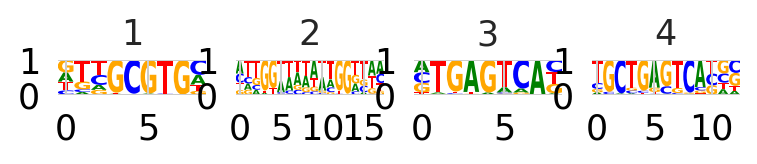

In [308]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=10, n_cols=12, stop_at=5) # n_cols=len(reduced_groups))

In [309]:
# model.binding_modes.prob_act

In [310]:
mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})
# mb.pl.conv(model, n_cols=2)


In [311]:
model.loss_history

[]

In [312]:
conn = model.selex_module.conn_sparse

In [313]:
self = model

conn = self.selex_module.conn_sparse
log_dynamic = self.selex_module.log_dynamic
idx = conn.indices()

# prepare combinations based on common indexes
uniq_idx = idx.unique()
all_combinations = []
for u_idx in uniq_idx:
    pos = torch.arange(idx.size(1))
    sub_pos = pos[(idx[:, :][0] == u_idx) | (idx[:, :][1] == u_idx)]
    c = torch.combinations(sub_pos, r=2)
    all_combinations.append(c)

all_pos = torch.cat(all_combinations)
pairs = idx[:, all_pos].reshape(all_pos.shape[0], 4)
# pairs = idx[all_pos].reshape(all_pos.shape[0], 4)
mask1 = (pairs[:, 0] == pairs[:, 2]) | (pairs[:, 1] == pairs[:, 3])
mask2 = (pairs[:, 0] != pairs[:, 1]) & (pairs[:, 2] != pairs[:, 3])

all_pos = all_pos[mask1 & mask2]
pairs = pairs[mask1 & mask2]

a = log_dynamic[all_pos[:, 0]]
b = log_dynamic[all_pos[:, 1]]

print(a)
print(b)


tensor([0.08, 0.08, 0.08,  ..., 0.64, 0.50, 0.28], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor([0.32, 0.56, 0.71,  ..., 0.64, 0.28, 0.64], device='cuda:0',
       grad_fn=<IndexBackward0>)


In [314]:
model, best_loss = model.optimize_iterative(train, n_epochs=[2] + [10] * (n_kernels + 1),
                                            show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                            opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                            opt_one_step=True,
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            skip_kernels=range(1, 500),
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                            exp_max=8,
                                            early_stopping=250, log_each=1, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 9 to (0, 0)
activities status False
setting grad status of kernel (mono, dinuc) at 10 to (0, 0)
activities status False
s

In [315]:
model.activities.log_activities[0].requires_grad

True

In [316]:
print(model.selex_module.log_dynamic)
print(model.selex_module.log_etas)

Parameter containing:
tensor([0.17, 0.50, 0.78,  ..., 0.42, 0.38, 0.54], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.09, -0.09, -0.09, -0.04, -0.04, -0.04, -0.08, -0.09, -0.09,  0.10,
         -0.08, -0.10,  0.02, -0.09,  0.01, -0.09, -0.09, -0.10, -0.08, -0.10,
         -0.10,  0.04, -0.09, -0.09, -0.07, -0.08,  0.08, -0.09, -0.10,  0.06,
         -0.10, -0.08, -0.04, -0.06, -0.08, -0.02, -0.09, -0.10,  0.01, -0.08,
         -0.07, -0.09, -0.10,  0.07,  0.09, -0.10,  0.09, -0.09, -0.07, -0.08,
         -0.10,  0.08, -0.09, -0.10, -0.09, -0.09, -0.05, -0.09,  0.09, -0.08,
          0.09,  0.08, -0.09,  0.10, -0.10, -0.10, -0.09,  0.01, -0.09,  0.08,
         -0.09, -0.07, -0.08,  0.05,  0.05, -0.09, -0.10, -0.09, -0.08, -0.08,
         -0.06, -0.03, -0.09, -0.09, -0.10, -0.09, -0.07,  0.09, -0.10,  0.09,
         -0.07, -0.08,  0.09, -0.05,  0.04,  0.09, -0.02, -0.02, -0.05, -0.09,
         -0.10, -0.10,  0.08, -0.09,  0.09, -0.09, -0.08,  0.01, -0.10,

In [317]:
torch.stack(list(model.activities.log_activities), dim=1)

tensor([[[-1.93e-06, -2.51e-06, -1.88e-06,  ...,  2.28e-06,  3.19e-06,
          -1.48e-06],
         [ 0.00e+00,  0.00e+00,  0.00e+00,  ...,  0.00e+00,  0.00e+00,
           0.00e+00],
         [-5.27e-02, -5.46e-02, -5.29e-02,  ...,  5.54e-02,  5.52e-02,
          -5.13e-02],
         ...,
         [-4.30e-02, -4.57e-02, -4.12e-02,  ...,  4.37e-02,  4.70e-02,
          -3.93e-02],
         [-2.30e-03, -1.78e-03, -1.69e-03,  ...,  2.32e-03,  2.39e-03,
          -1.20e-03],
         [-1.68e-03, -1.92e-03, -1.24e-03,  ...,  1.77e-03,  2.72e-03,
          -1.24e-03]]], device='cuda:0', grad_fn=<StackBackward0>)

In [318]:
atac.shape

(16918, 228259)

Text(0, 0.5, 'similar weights loss')

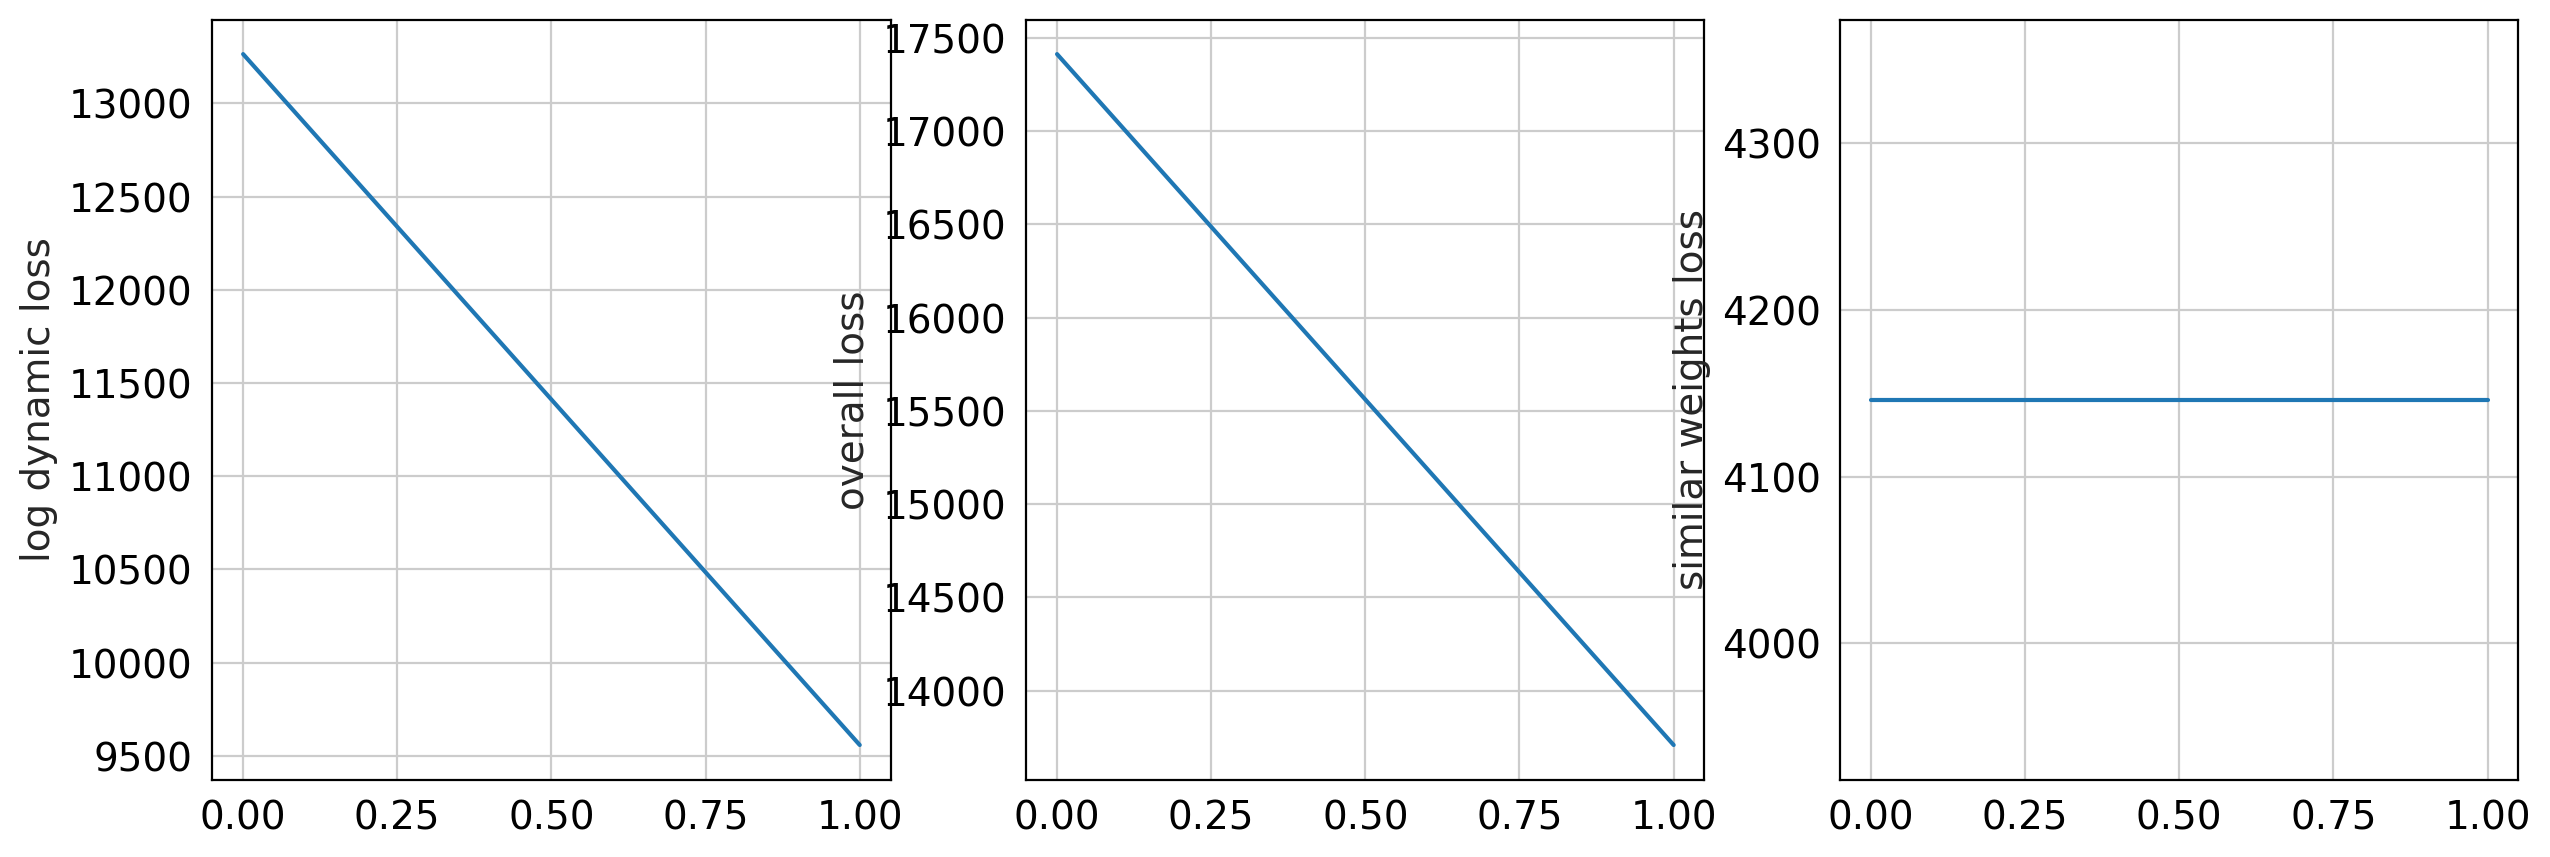

In [319]:
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')


In [320]:
print('here...')

here...


True
1
0 out of 288...
10 out of 288...


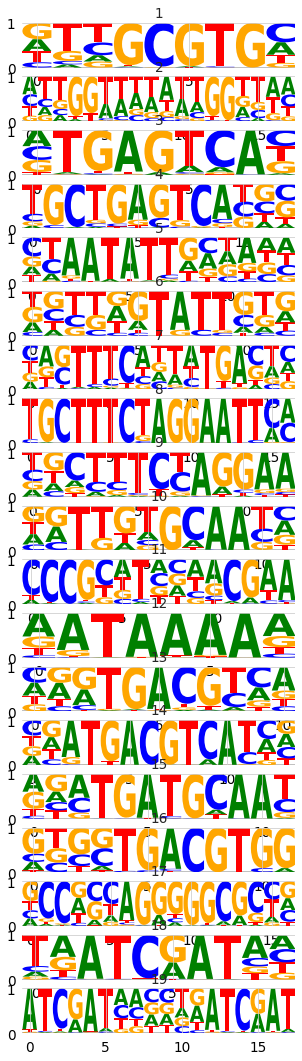

In [375]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 20
rcParams['figure.dpi'] = 35
mb.pl.conv(model, n_cols=1, n_rows=20, show=True, stop_at=20)
plt.show()


In [322]:
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# connectivities
C = model.selex_module.conn_sparse
a_ind = C.indices()

log_dynamic = model.selex_module.log_dynamic
D = model.selex_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
D = D_tril + t(D_triu, 0, 1)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
D

tensor(indices=tensor([[  0,   0,   0,  ..., 217, 231, 248],
                       [  4,  20,  22,  ..., 349, 349, 349]]),
       values=tensor([ 0.17,  0.50,  0.78,  ..., -0.42, -0.38, -0.54]),
       device='cuda:0', size=(350, 350), nnz=13084, layout=torch.sparse_coo,
       grad_fn=<AddBackward0>)

<AxesSubplot: >

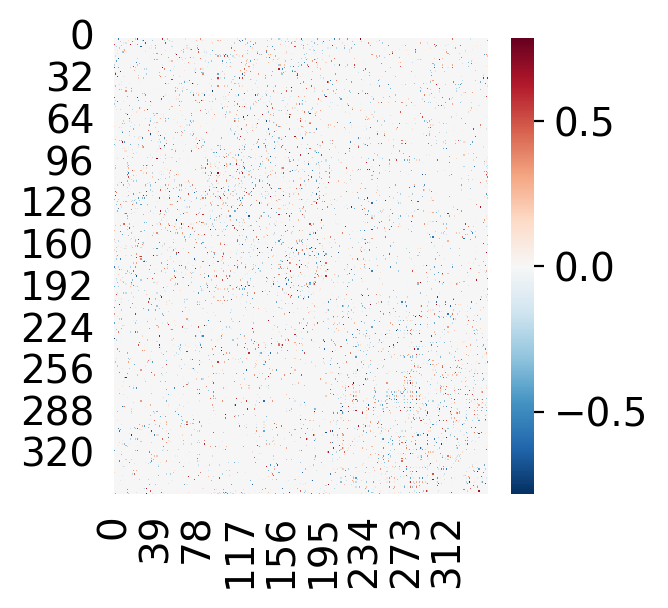

In [323]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')

In [324]:
model.best_r2_by_new_filter

[]

In [325]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
if len(model.best_r2_by_new_filter) != 0:
    r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
    sns.barplot(data=r2, x='index', y='r2')

In [326]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
if len(model.best_r2_by_new_filter) != 0:
    r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
    sns.barplot(data=r2, x='index', y='r2')

In [327]:
torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)


In [328]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

Text(0.5, 12.355555555555531, 'dynamic score (normalized)')

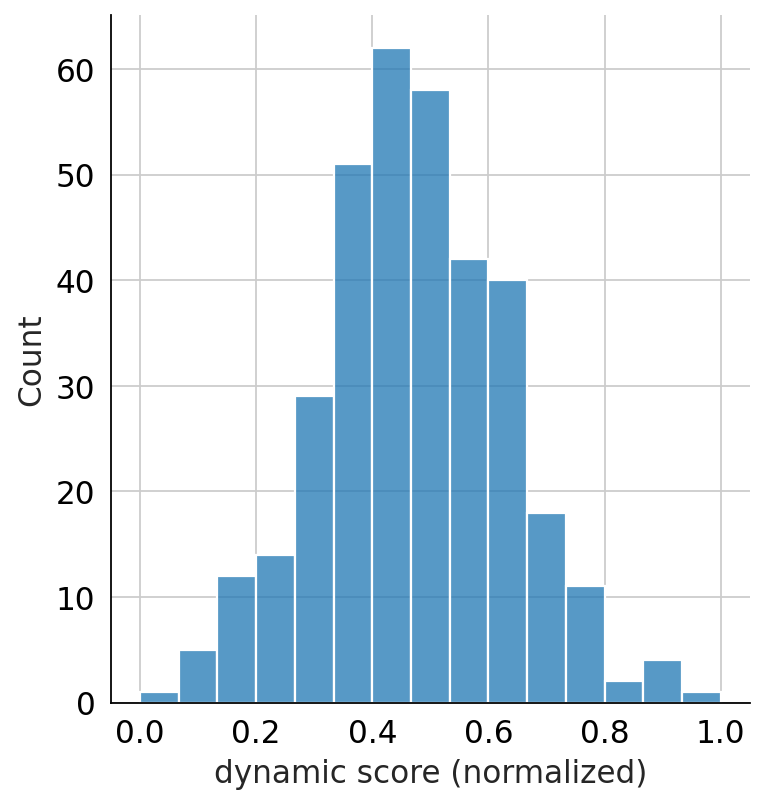

In [329]:
ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dynamic_score, bins=15)
plt.xlabel('dynamic score (normalized)')


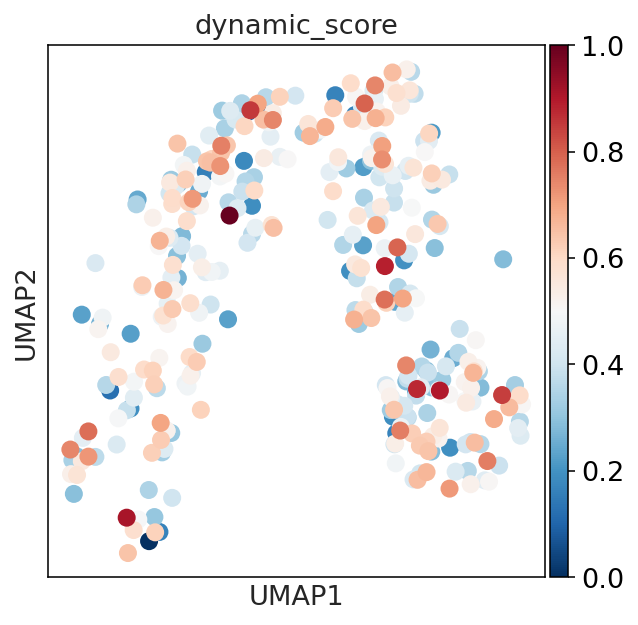

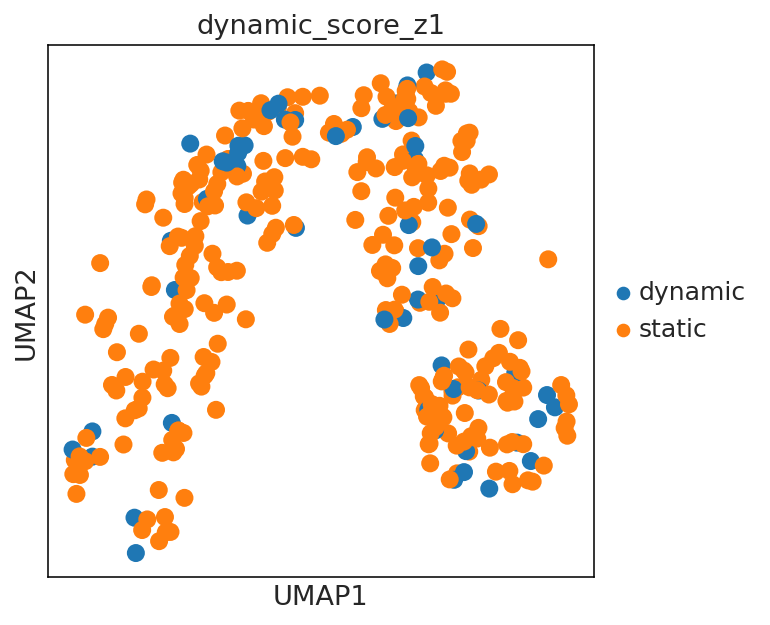

In [330]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 70
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [331]:
ad.obs['dynamic_score_z1']

AAAGCACCACTAAGAA-1-0    static
AACCTCACAAGGTCCT-1-0    static
AACGCCCAGTTAGCTA-1-0    static
AACGGTAAGTTTGAGC-1-0    static
AACTCACAGTTATCTC-1-0    static
                         ...  
TTGTGCCTCCTTGTTG-1-1    static
TTTACGAAGTGTGATC-1-1    static
TTTACGCGTGTTTGCT-1-1    static
TTTAGCTTCATAAGCC-1-1    static
TTTCATCAGGTGTTAC-1-1    static
Name: dynamic_score_z1, Length: 350, dtype: category
Categories (2, object): ['dynamic', 'static']

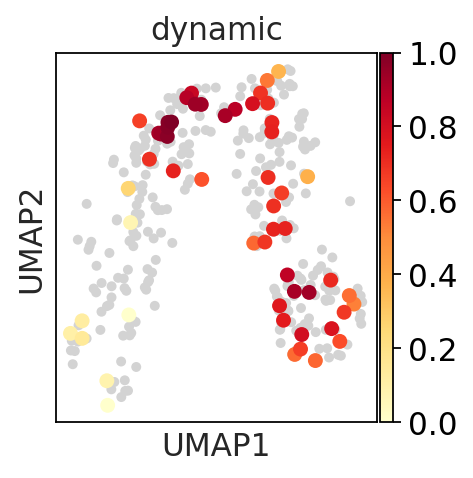

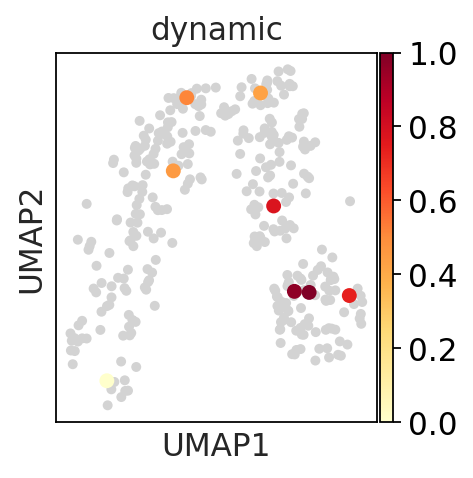

In [332]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

In [333]:
sc.set_figure_params()

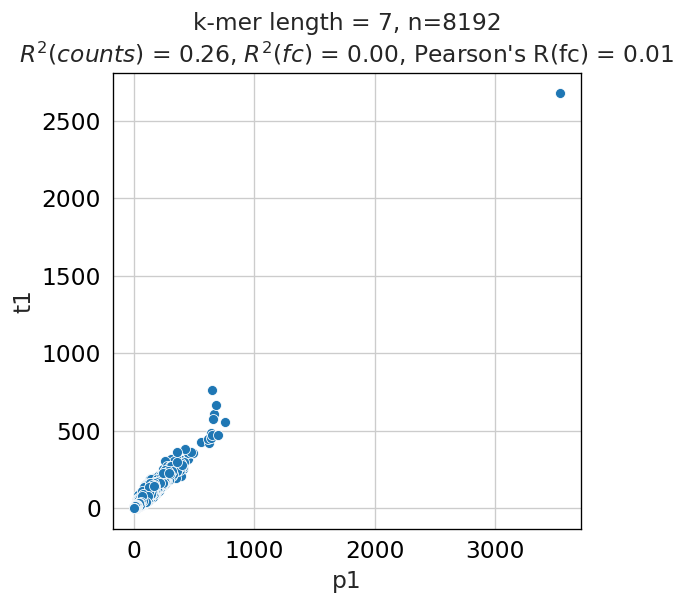

{'r2_counts': 0.2615824662840621,
 'r2_foldchange': -0.0010645412461980364,
 'r2_enr': -0.03785500030578559,
 'r2_fc': 4.867789426700571e-05,
 'pearson_foldchange': 0.00697695451232167}

In [334]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 60})
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=7)


In [335]:
umap = ad.obsm['X_umap'].copy()
umap = np.sort(umap, 0)

x = umap[:,0]
y = umap[:,1]
X, Y = np.meshgrid(x, y)

n_points = x.shape[0]
# x-component to the right
u = np.ones((n_points, n_points))
# y-component zero
v = np.zeros((n_points, n_points))

In [336]:
D.shape

torch.Size([350, 350])

In [337]:
import scvelo as scv

In [338]:
ad.shape

(350, 619)

In [339]:
torch.stack(list(model.activities.log_activities), dim=1)

tensor([[[-1.93e-06, -2.51e-06, -1.88e-06,  ...,  2.28e-06,  3.19e-06,
          -1.48e-06],
         [ 0.00e+00,  0.00e+00,  0.00e+00,  ...,  0.00e+00,  0.00e+00,
           0.00e+00],
         [-5.27e-02, -5.46e-02, -5.29e-02,  ...,  5.54e-02,  5.52e-02,
          -5.13e-02],
         ...,
         [-4.30e-02, -4.57e-02, -4.12e-02,  ...,  4.37e-02,  4.70e-02,
          -3.93e-02],
         [-2.30e-03, -1.78e-03, -1.69e-03,  ...,  2.32e-03,  2.39e-03,
          -1.20e-03],
         [-1.68e-03, -1.92e-03, -1.24e-03,  ...,  1.77e-03,  2.72e-03,
          -1.24e-03]]], device='cuda:0', grad_fn=<StackBackward0>)

In [340]:
log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
log_act.shape

torch.Size([350, 288])

In [341]:
train.dataset.mononuc.shape

(619, 4, 1000)

In [342]:
pred = []
for i, batch in enumerate(train):
    # Get a batch and potentially send it to GPU memory.
    mononuc = batch["mononuc"].to(device)
    # print(i, mononuc.shape)
    b = batch["batch"].to(device) if "batch" in batch else None
    rounds = batch["rounds"].to(device) if "rounds" in batch else None
    countsum = batch["countsum"].to(device) if "countsum" in batch else None
    seq = batch["seq"] if "seq" in batch else None
    residues = batch["residues"].to(device) if "residues" in batch else None
    if residues is not None and train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                  "residues": residues}
    elif residues is not None:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
    elif train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
    else:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

    inputs['scale_countsum'] = model.datatype == 'selex'
    output = model(**inputs, use_conn=False)

    output = output.cpu().detach().numpy()
    print('here...')
    print(output.shape)

    print(output.sum())
    pred.append(output)

pred = np.concatenate(pred).T
ad.layers['velocity'] = pred
ad.layers['counts'] = ad.X

here...
(128, 350)
43117.0
here...
(128, 350)
53485.996
here...
(128, 350)
37370.0
here...
(128, 350)
45925.004
here...
(107, 350)
32736.0


In [343]:
ad.layers['counts']

<350x619 sparse matrix of type '<class 'numpy.float32'>'
	with 62769 stored elements in Compressed Sparse Row format>

(array([1122., 1792., 1060.,  678.,  434.,  282.,  216.,  186.,  110.,
         662.]),
 array([1.89487125e-07, 1.00000173e-01, 2.00000152e-01, 3.00000131e-01,
        4.00000125e-01, 5.00000119e-01, 6.00000083e-01, 7.00000048e-01,
        8.00000012e-01, 9.00000036e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

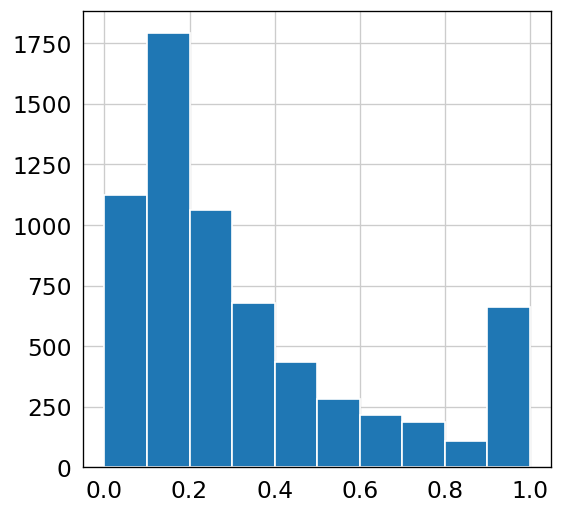

In [344]:
plt.hist(model.selex_module.conn_sparse.values().detach().cpu().numpy())

In [345]:
pred.shape

(350, 619)

In [346]:
ad.shape

(350, 619)

In [347]:
sc.pp.neighbors(ad)

In [348]:
# ad.layers['log_act'] = dyn_umap.X
# ad.layers['counts'] = ad.X
scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')

computing velocity graph (using 1/16 cores)


  0%|          | 0/350 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


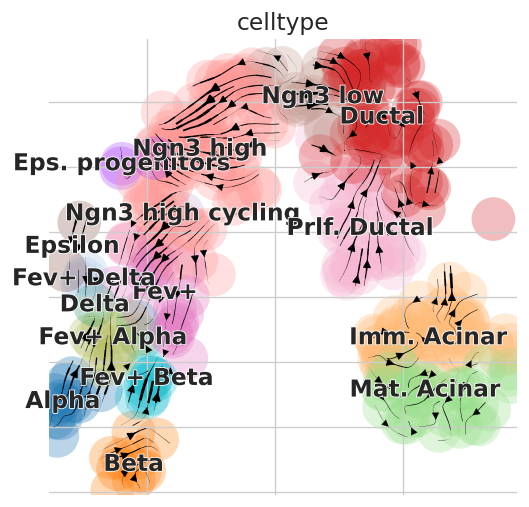

In [349]:
scv.pl.velocity_embedding_stream(ad, color='celltype') #  X_grid='X_umap', V=V)


In [350]:
ad.shape

(350, 619)

In [351]:
act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
# log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
# log_act


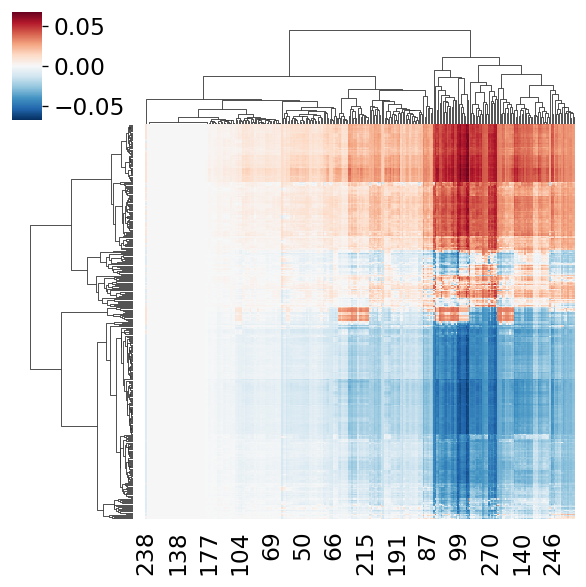

In [352]:
vmax = act.abs().max()
sns.clustermap(act.detach().cpu().numpy(), cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

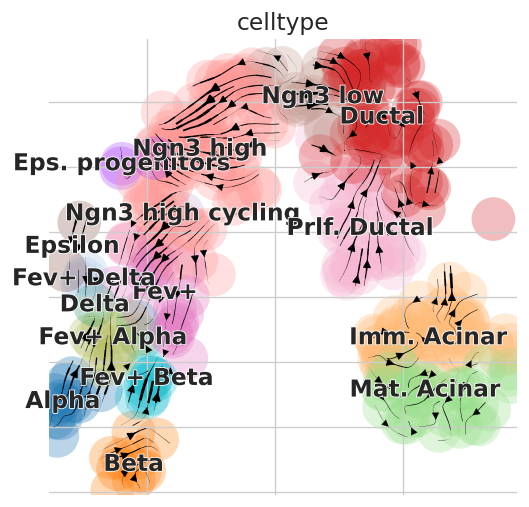

In [353]:
scv.pl.velocity_embedding_stream(ad, color='celltype') #  X_grid='X_umap', V=V)

In [354]:
rna_sel = rna[rna.obs_names.isin(ad.obs_names),:].copy()


In [355]:
rna_sel.var[rna_sel.var_names.str.startswith('Neu')]

modality
Neu2         GEX
Neurod1      GEX
Neurl2       GEX
Neu3         GEX
Neurog3      GEX
Neurl4       GEX
Neurod2      GEX
Neurl1b      GEX
Neu1         GEX
Neurl1a      GEX

In [356]:
rna.var_names[rna.var_names == 'Neurog3']

Index(['Neurog3'], dtype='object')

In [357]:
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'

In [358]:
anno.columns

Index(['Cluster_ID', 'Name', 'DBD', 'Seed_motif', 'Total_width',
       'Consensus_left', 'Consensus_right', 'Cluster_size'],
      dtype='object')

In [359]:
# sns.clustermap(log_act.detach().numpy())

In [360]:
for i in range(2, log_act.shape[1]):
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [361]:
log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
log_act = pd.DataFrame(log_act.detach().cpu().numpy())
# log_act.columns = anno['Seed_motif'][2]
log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
log_act.index = ad.obs_names
ad.obsm['mubind_activities'] = log_act

In [362]:
for c in ad.obsm['mubind_activities']:
    ad.obs[c] = ad.obsm['mubind_activities'][c]

In [363]:
names_neurog = anno[anno['Cluster_ID'].isin(set(clu[clu['Motif'].str.contains('NEU')]['Cluster_ID'].values))]['Seed_motif'].values


In [364]:
names_clu = list(anno['Seed_motif'].values)

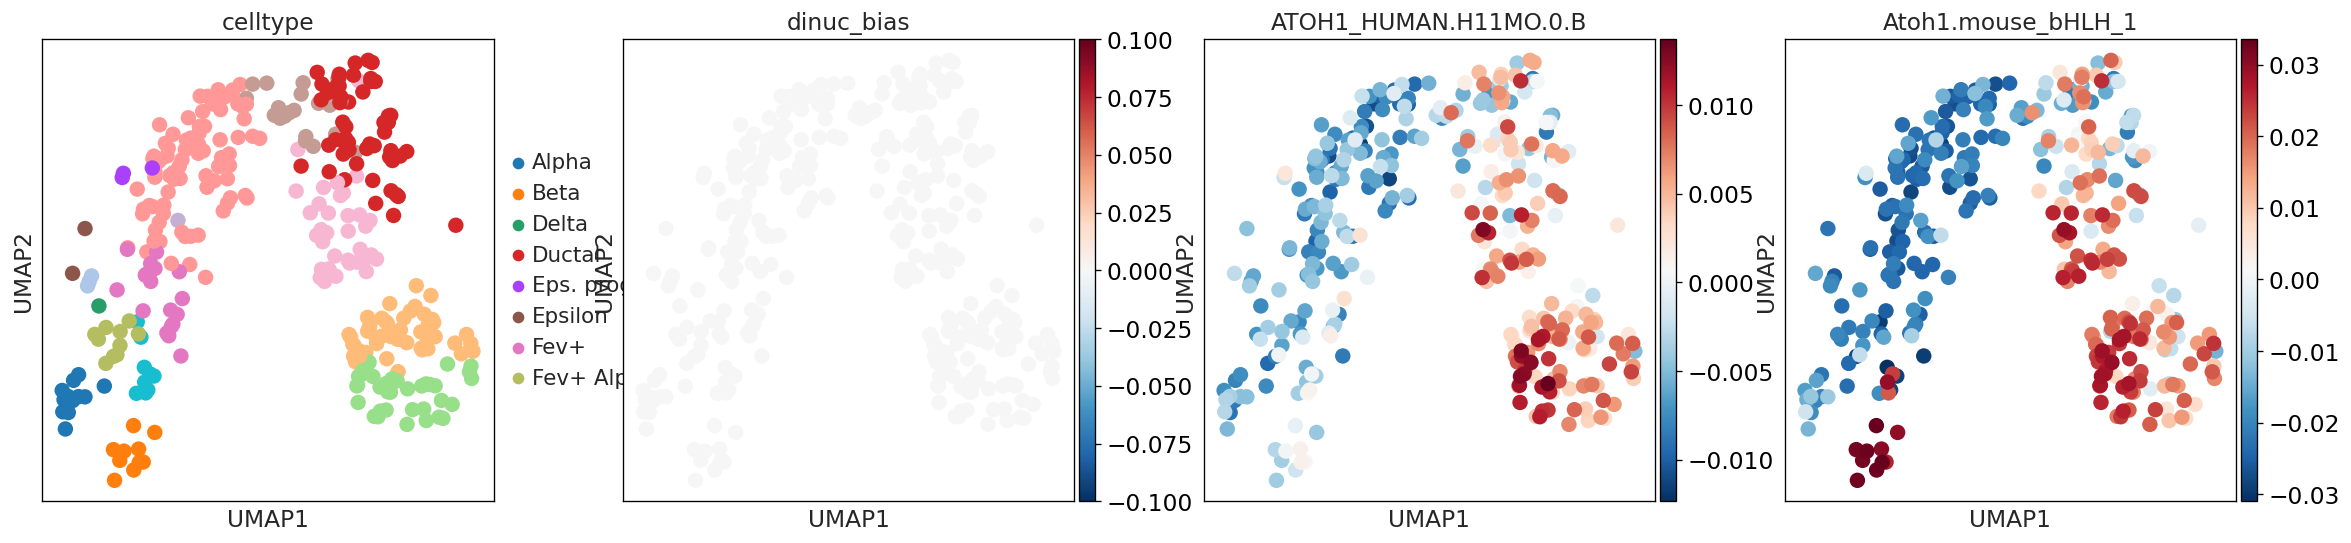

In [365]:

sc.pl.umap(ad, color=['celltype', 'dinuc_bias'] + list(names_neurog), cmap='RdBu_r', ncols=5)


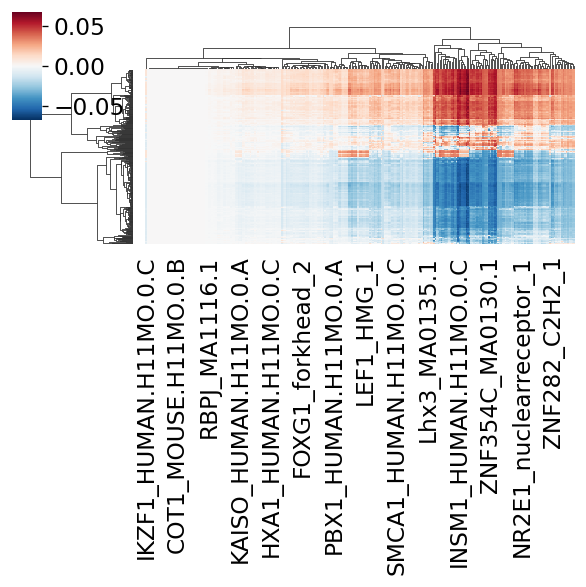

In [366]:
sns.clustermap(log_act, cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

In [367]:
log_act

intercept  dinuc_bias  AHR_HUMAN.H11MO.0.B  \
AAAGCACCACTAAGAA-1-0 -1.926032e-06         0.0            -0.052714   
AACCTCACAAGGTCCT-1-0 -2.509177e-06         0.0            -0.054632   
AACGCCCAGTTAGCTA-1-0 -1.879574e-06         0.0            -0.052879   
AACGGTAAGTTTGAGC-1-0  3.019404e-08         0.0            -0.020383   
AACTCACAGTTATCTC-1-0 -1.411659e-07         0.0            -0.009115   
...                            ...         ...                  ...   
TTGTGCCTCCTTGTTG-1-1 -9.993208e-07         0.0            -0.045729   
TTTACGAAGTGTGATC-1-1  1.498786e-06         0.0             0.046709   
TTTACGCGTGTTTGCT-1-1  2.278992e-06         0.0             0.055356   
TTTAGCTTCATAAGCC-1-1  3.192946e-06         0.0             0.055234   
TTTCATCAGGTGTTAC-1-1 -1.479869e-06         0.0            -0.051310   

                      AIRE_HUMAN.H11MO.0.C  ATF3_MOUSE.H11MO.0.A  \
AAAGCACCACTAAGAA-1-0             -0.003789             -0.020233   
AACCTCACAAGGTCCT-1-0             -0.005276             -0.021183   
AACGCCCAGTTAGCTA-1-0             -0.002850             -0.017205   
AACGGTAAGTTTGAGC-1-0              0.000176              0.008000   
AACTCACAGTTATCTC-1-0              0.000579             -0.005181   
...                                    ...                   ...   
TTGTGCCTCCTTGTTG-1-1             -0.002770             -0.013961   
TTTACGAAGTGTGATC-1-1              0.002424              0.016459   
TTTACGCGTGTTTGCT-1-1              0.004152              0.021336   
TTTAGCTTCATAAGCC-1-1              0.006202              0.022629   
TTTCATCAGGTGTTAC-1-1             -0.002482             -0.016855   

                      BACH1_HUMAN.H11MO.0.A  Arid5a_MA0602.1  \
AAAGCACCACTAAGAA-1-0              -0.007991        -0.006803   
AACCTCACAAGGTCCT-1-0              -0.009003        -0.009587   
AACGCCCAGTTAGCTA-1-0              -0.006759        -0.005480   
AACGGTAAGTTTGAGC-1-0               0.000350         0.000274   
AACTCACAGTTATCTC-1-0              -0.000782         0.001411   
...                                     ...              ...   
TTGTGCCTCCTTGTTG-1-1              -0.005709        -0.005668   
TTTACGAAGTGTGATC-1-1               0.003667         0.004620   
TTTACGCGTGTTTGCT-1-1               0.010023         0.007374   
TTTAGCTTCATAAGCC-1-1               0.011622         0.010724   
TTTCATCAGGTGTTAC-1-1              -0.007509        -0.004963   

                      ARI5B_HUMAN.H11MO.0.C  BATF3_HUMAN.H11MO.0.B  \
AAAGCACCACTAAGAA-1-0              -0.032717              -0.036855   
AACCTCACAAGGTCCT-1-0              -0.034853              -0.038415   
AACGCCCAGTTAGCTA-1-0              -0.034877              -0.038494   
AACGGTAAGTTTGAGC-1-0              -0.015095              -0.023666   
AACTCACAGTTATCTC-1-0               0.010536               0.018875   
...                                     ...                    ...   
TTGTGCCTCCTTGTTG-1-1              -0.026008              -0.033329   
TTTACGAAGTGTGATC-1-1               0.034609               0.038215   
TTTACGCGTGTTTGCT-1-1               0.035177               0.038389   
TTTAGCTTCATAAGCC-1-1               0.037978               0.039874   
TTTCATCAGGTGTTAC-1-1              -0.031460              -0.036690   

                      BCL6B_C2H2_1  ...  ZN667_HUMAN.H11MO.0.C  \
AAAGCACCACTAAGAA-1-0     -0.001170  ...                    0.0   
AACCTCACAAGGTCCT-1-0     -0.000809  ...                    0.0   
AACGCCCAGTTAGCTA-1-0     -0.000768  ...                    0.0   
AACGGTAAGTTTGAGC-1-0      0.000097  ...                    0.0   
AACTCACAGTTATCTC-1-0     -0.000185  ...                    0.0   
...                            ...  ...                    ...   
TTGTGCCTCCTTGTTG-1-1     -0.000356  ...                    0.0   
TTTACGAAGTGTGATC-1-1      0.000930  ...                    0.0   
TTTACGCGTGTTTGCT-1-1      0.001163  ...                    0.0   
TTTAGCTTCATAAGCC-1-1      0.001272  ...                    0.0   
TTTCATCAGGTGTTAC-1-

Text(0.5, 1.0, 'TF modules (by score)')

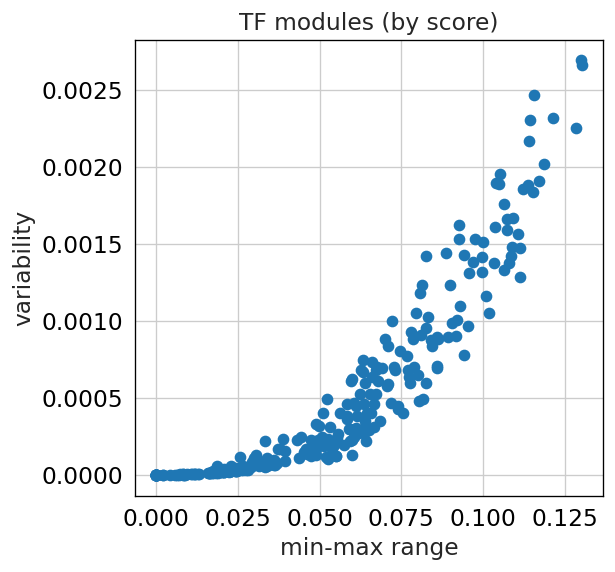

In [368]:
delta = (log_act.max(axis=0) - log_act.min(axis=0))
var = log_act.var(axis=0)
plt.scatter(delta, var)
plt.xlabel('min-max range')
plt.ylabel('variability')
plt.title('TF modules (by score)')

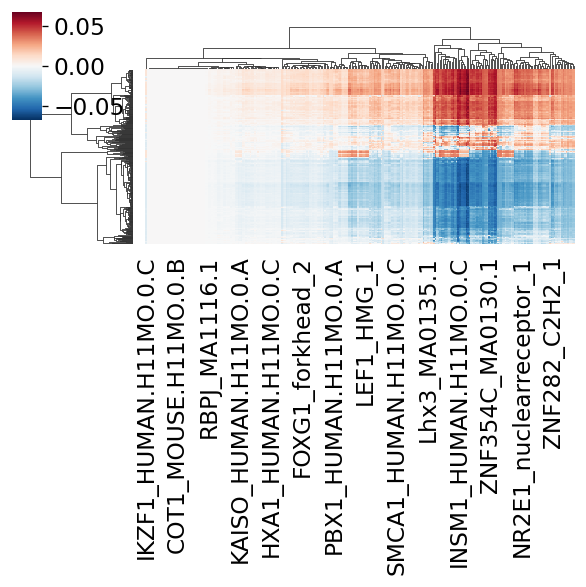

In [369]:
sns.clustermap(log_act, cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

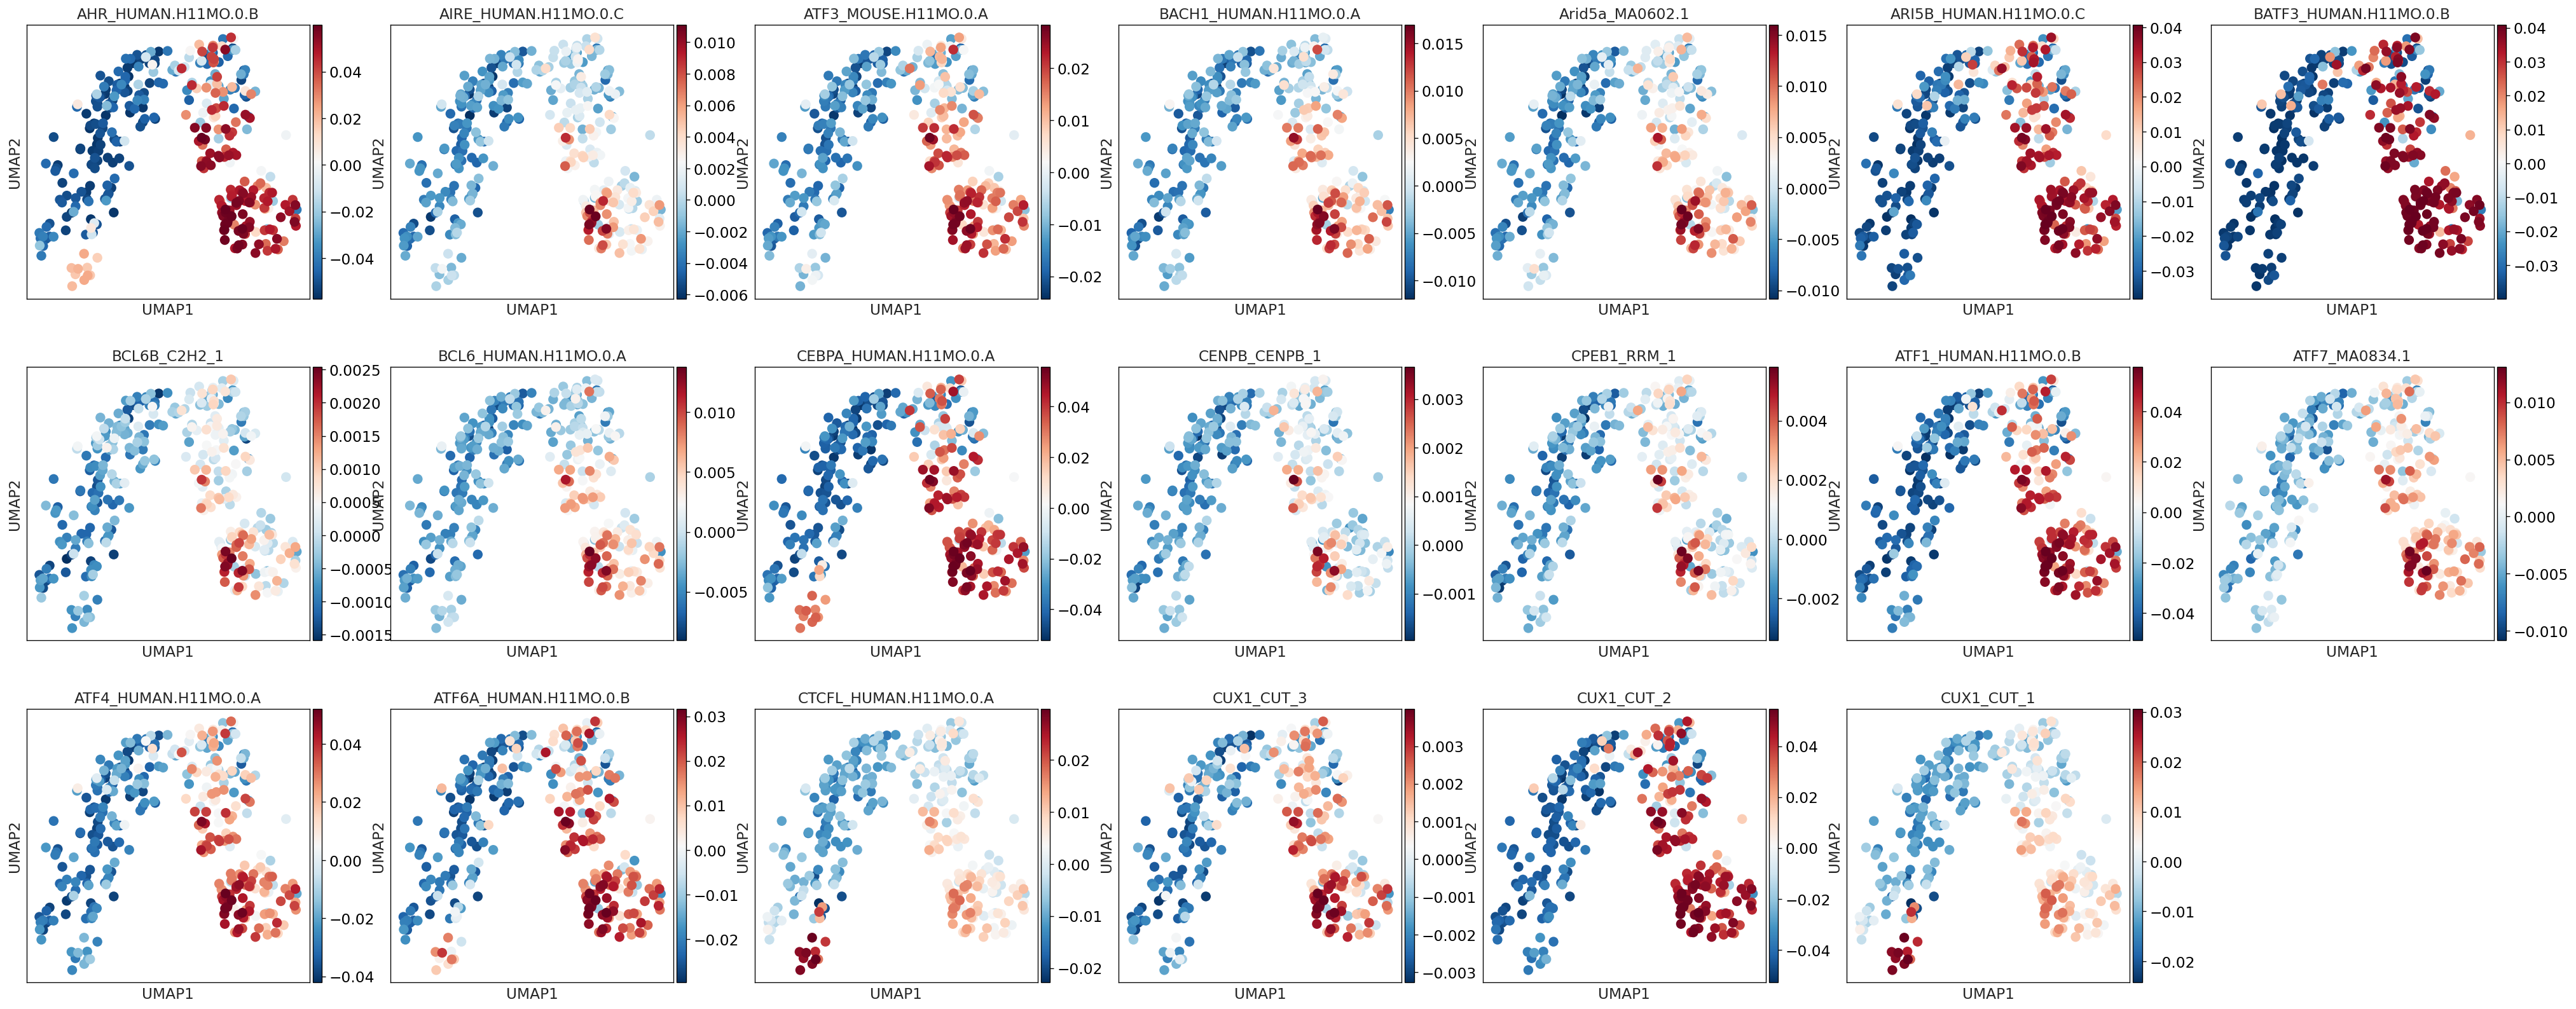

In [370]:
sc.pl.umap(ad, color=names_clu[:20], cmap='RdBu_r', ncols=7)


In [371]:
rna_sel.obs['score'] = log_act[:,63].detach().cpu().numpy()

InvalidIndexError: (slice(None, None, None), 63)

In [ ]:
sc.pl.umap(rna_sel, color=['celltype', 'score', 'dinuc_bias'], cmap='RdBu_r')
